In [1]:
!python -V
#for Mlops python verison 3.9.18

Python 3.9.18


In [2]:
#Install shell
#!pip install mlflow
#%pip install xgboost 

In [3]:
#Import Library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle
import mlflow

In [4]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/osama/Mlops/Part-2/experiment_tracking/mlruns/1', creation_time=1706873287173, experiment_id='1', last_update_time=1706873287173, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [7]:
len(df_train), len(df_val)

(65946, 62574)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_'+ df_val['DOLocationID']

In [9]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,1,2023-02-01 00:46:22,2023-02-01 01:05:57,N,1.0,74,265,1.0,10.80,42.90,...,0.00,0.0,NaN,1.0,45.40,2.0,1.0,0.00,19.583333,74_265
1,2,2023-02-01 00:05:09,2023-02-01 00:22:42,N,1.0,216,196,1.0,4.76,23.30,...,0.00,0.0,NaN,1.0,25.80,2.0,1.0,0.00,17.550000,216_196
2,2,2023-02-01 00:03:47,2023-02-01 00:27:30,N,1.0,7,114,1.0,6.32,30.30,...,8.89,0.0,NaN,1.0,44.44,1.0,1.0,2.75,23.716667,7_114
3,2,2023-01-31 23:30:56,2023-01-31 23:51:40,N,1.0,74,239,1.0,3.50,16.30,...,0.00,0.0,NaN,1.0,21.55,2.0,1.0,2.75,20.733333,74_239
4,2,2023-02-01 00:15:05,2023-02-01 00:26:02,N,1.0,82,223,1.0,3.14,17.00,...,0.00,0.0,NaN,1.0,19.50,2.0,1.0,0.00,10.950000,82_223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64804,2,2023-02-28 21:49:00,2023-02-28 22:04:00,None,NaN,7,263,NaN,3.83,16.70,...,2.00,0.0,NaN,1.0,22.45,NaN,NaN,NaN,15.000000,7_263
64805,2,2023-02-28 21:05:00,2023-02-28 21:08:00,None,NaN,41,42,NaN,0.67,12.95,...,2.79,0.0,NaN,1.0,16.74,NaN,NaN,NaN,3.000000,41_42
64806,2,2023-02-28 22:42:00,2023-02-28 22:59:00,None,NaN,166,141,NaN,3.91,19.60,...,3.50,0.0,NaN,1.0,26.85,NaN,NaN,NaN,17.000000,166_141
64807,2,2023-02-28 23:21:00,2023-02-28 23:38:00,None,NaN,41,244,NaN,4.54,19.36,...,4.07,0.0,NaN,1.0,24.43,NaN,NaN,NaN,17.000000,41_244


In [10]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'

y_train = df_train[target].values

y_val = df_val[target].values

In [12]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred =  lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.036975271332868

/home/osama/anaconda3/envs/Mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/osama/anaconda3/envs/Mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


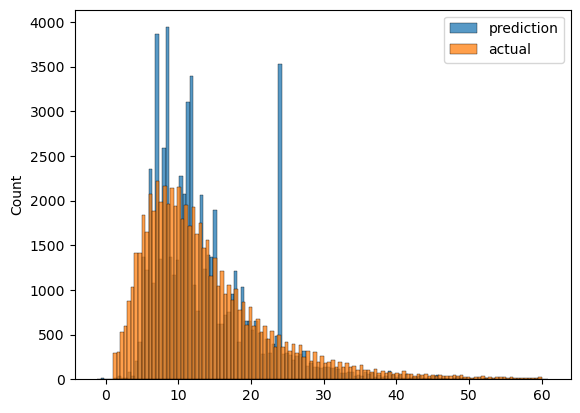

In [13]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')
plt.legend()

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
#Normal 
with mlflow.start_run():
    mlflow.set_tag("developer", "Osama")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet'")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_red = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")
    

In [19]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params= params,
            dtrain=train,
            num_boost_round = 1000,
            evals=[(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.lognormal('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective' : 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10, #take long time to train
    trials=Trials()
)

[11:51:40] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.68311                          
[1]	validation-rmse:14.99872                          
[2]	validation-rmse:14.35224                          
[3]	validation-rmse:13.74207                          
[4]	validation-rmse:13.16656                          
[5]	validation-rmse:12.62457                          
[6]	validation-rmse:12.11295                          
[7]	validation-rmse:11.63189                          
[8]	validation-rmse:11.17972                          
  0%|          | 0/10 [00:03<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
'''
learning_rate	0.049787068367863944
max_depth	45
min_child_weight	2.501153802179065
objective	reg:linear
reg_alpha	0.17057509833056017
reg_lambda	0.33586884538545975
seed	42 
'''

In [22]:
params = {
    "learning_rate" : 0.049787068367863944,
    "max_depth":45,
    "min_child_weight" : 2.501153802179065,
    "objective" :'reg:linear',
    "reg_alpha" :	0.17057509833056017,
    "reg_lambda" :	0.33586884538545975,
    "seed":	42,
}

mlflow.xgboost.autolog()

booster = xgb.train(
        params= params,
        dtrain=train,
        num_boost_round = 1000,
        evals=[(valid, "validation")],
        early_stopping_rounds = 50
    )


2024/02/05 14:23:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e6be93b709034c4396f1218707789466', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[14:23:46] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.67962
[1]	validation-rmse:14.99170
[2]	validation-rmse:14.34206
[3]	validation-rmse:13.72907
[4]	validation-rmse:13.15067
[5]	validation-rmse:12.60570
[6]	validation-rmse:12.09260
[7]	validation-rmse:11.61008
[8]	validation-rmse:11.15606
[9]	validation-rmse:10.72912
[10]	validation-rmse:10.32829
[11]	validation-rmse:9.95175
[12]	validation-rmse:9.59903
[13]	validation-rmse:9.26907
[14]	validation-rmse:8.95979
[15]	validation-rmse:8.67142
[16]	validation-rmse:8.40189
[17]	validation-rmse:8.15110
[18]	validation-rmse:7.91796
[19]	validation-rmse:7.70063
[20]	validation-rmse:7.49946
[21]	validation-rmse:7.31181
[22]	validation-rmse:7.13779
[23]	validation-rmse:6.97647
[24]	validation-rmse:6.82822
[25]	validation-rmse:6.69155
[26]	validation-rmse:6.56431
[27]	validation-rmse:6.44915
[28]	validation-rmse:6.34217
[2

2024/02/05 14:24:37 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/02/05 14:24:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/osama/anaconda3/envs/Mlops/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
mlflow.xgboost.autolog(disable=True)

In [23]:
with mlflow.start_run():
    best_params = {
    "learning_rate" : 0.049787068367863944,
    "max_depth":45,
    "min_child_weight" : 2.501153802179065,
    "objective" :'reg:linear',
    "reg_alpha" :	0.17057509833056017,
    "reg_lambda" :	0.33586884538545975,
    "seed":	42,
}
    mlflow.log_params(best_params)

    mlflow.xgboost.autolog()

    booster = xgb.train(
        params= best_params,
        dtrain=train,
        num_boost_round = 1000,
        evals=[(valid, "validation")],
        early_stopping_rounds = 50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

[11:51:51] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.67962
[1]	validation-rmse:14.99170
[2]	validation-rmse:14.34206
[3]	validation-rmse:13.72907
[4]	validation-rmse:13.15067
[5]	validation-rmse:12.60570
[6]	validation-rmse:12.09260
[7]	validation-rmse:11.61008
[8]	validation-rmse:11.15606
[9]	validation-rmse:10.72912
[10]	validation-rmse:10.32829
[11]	validation-rmse:9.95175
[12]	validation-rmse:9.59903
[13]	validation-rmse:9.26907
[14]	validation-rmse:8.95979
[15]	validation-rmse:8.67142
[16]	validation-rmse:8.40189
[17]	validation-rmse:8.15110
[18]	validation-rmse:7.91796
[19]	validation-rmse:7.70063
[20]	validation-rmse:7.49946
[21]	validation-rmse:7.31181
[22]	validation-rmse:7.13779
[23]	validation-rmse:6.97647
[24]	validation-rmse:6.82822
[25]	validation-rmse:6.69155
[26]	validation-rmse:6.56431
[27]	validation-rmse:6.44915
[28]	validation-rmse:6.34217
[2

2024/02/06 11:52:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/osama/anaconda3/envs/Mlops/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
